<a href="https://colab.research.google.com/github/Fouad-Khelil/Fouad-Khelil/blob/main/federated_learning_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code Adapted from: [Link](https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
! pip install -q tensorflow_federated

In [ ]:
from __future__ import absolute_import, division, print_function


import collections
from six.moves import range
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.optimizer_v2 import gradient_descent
from tensorflow_federated import python as tff
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.python.util import nest

np.random.seed(0)

tf.compat.v1.enable_v2_behavior()

## EMNIST Dataset

To illustrate the use of FL and TFF, let’s start with one of the most famous image datasets: MNIST. The [original NIST](https://www.nist.gov/srd/nist-special-database-19) dataset, from which MNIST was created, contains images of 810,000 handwritten digits. The traditional way we’d go about it is to apply an ML algorithm to the entire dataset at once. But what if we couldn’t combine all that data together — for example, because the volunteers did not agree to uploading their raw data to a central server?

#### MNIST
Creating a custom federated training data from MNIST dataset with 60 clients (as 60,000 examples of MNIST).

#### EMNIST Data set sizes:

*only_digits=True*: 3,383 users, 10 label classes

  -   train: 341,873 examples
  -   test: 40,832 examples

*only_digits=False*: 3,400 users, 62 label classes

  -   train: 671,585 examples
  -   test: 77,483 examples



In [ ]:
# load emnist dataset
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()


In [ ]:
# number of clients
len(emnist_train.client_ids)

3383

In [ ]:
# output types and shapes
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

### Sample Example from Dataset

In [ ]:
#get one example from client:0
example_dataset = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[10])

example_element = iter(example_dataset).next()

example_element['label'].numpy()

4

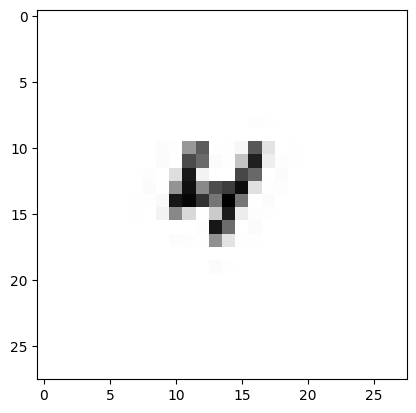

In [ ]:
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
plt.show()

### Preprocess data and create Keras model

What we'll do  is sample the set of clients once, and reuse the same set across rounds to speed up convergence (intentionally over-fitting to these few user's data).

In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 20
SHUFFLE_BUFFER = 500


def preprocess(dataset):

  def element_fn(element):
    return collections.OrderedDict([
        ('x', tf.reshape(element['pixels'], [-1])),
        ('y', tf.reshape(element['label'], [1])),
    ])

  return dataset.repeat(NUM_EPOCHS).map(element_fn).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)


In [ ]:
#print sample batch
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = nest.map_structure(lambda x: x.numpy(), iter(preprocessed_example_dataset).next())

print (sample_batch)

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)), ('y', array([[0],
       [1],
       [0],
       [6],
       [9],
       [4],
       [1],
       [4],
       [0],
       [7],
       [5],
       [9],
       [0],
       [3],
       [3],
       [7],
       [2],
       [3],
       [8],
       [8]], dtype=int32))])


In [ ]:
def make_federated_data(client_data, client_ids):
  return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

In [ ]:
# sample data for only 8 clients (fixed for now) for each round

NUM_CLIENTS = 8

sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print (len(federated_train_data), federated_train_data[0])

8 <_BatchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>


In [ ]:
# create keras model

def model_fn():
  # dense layer
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(10, activation=tf.nn.softmax, kernel_initializer='zeros', input_shape=(784,))])

  return tff.learning.models.from_keras_model(
    keras_model=model,
    input_spec=federated_train_data[0].element_spec,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [ ]:
# construct a Federated Averaging algorithm by invoking the helper function
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
    )

TFF has constructed a pair of federated computations and packaged them into a tff.utils.IterativeProcess in which these computations are available as a pair of properties `initialize` and `next`.

In [ ]:
# initialize computation to construct the server state.

state = iterative_process.initialize()

In [ ]:
# second of pair next  epresents a single round of Federated Averaging,
# which consists of pushing the server state (including the model parameters) to the clients,
# on-device training on their local data, collecting and averaging model updates,
# and producing a new updated model at the server.
# SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS

for round_num in range(1, 30):
  state, metrics = iterative_process.next(state, federated_train_data)
  print(f'round {round_num, metrics}')



round (1, OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.14541936), ('loss', 2.9879026), ('num_examples', 7750), ('num_batches', 391)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))]))
round (2, OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.18219355), ('loss', 2.7422912), ('num_examples', 7750), ('num_batches', 391)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))]))
round (3, OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.22722581), ('loss', 2.5213387), ('num_examples', 7750), ('num_batches', 391)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict(

Training loss seems to be converging.